In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import ndimage
import os
import shutil

In [ ]:
## STEP 1：Put the image in the current directory and enter the file name here
image_name = '8.jpg'  # Replace with your own image file name
image_type = "afm"    # Use "mask" for mask images, "afm" for AFM images
image_scale = 1000    # Image side length in nm. Scaling: 1 pix = 2 nm
if_bunch = False      # Whether to perform bunching
bunch_mode = "auto"   # Bunching mode if bunching is enabled
# "auto"   Automatically calculate the number of bunches
# "only"   Fix bunches to 1; can also be used to smooth the path
# "rough"  Bunches set to 1 or 2
# <number> Specify any integer for the exact number of bunches

In [ ]:
## STEP 2: Create working directories
### Check if a "data" folder exists in the current directory for storing results; if not, create it
if not os.path.exists('data'):
    os.makedirs('data')

### Create a sub-folder under "data" named after image_name and move the image into it
if not os.path.exists(os.path.join('data', image_name)):
    os.makedirs(os.path.join('data', image_name))

### Record the current directory of the image; will be used later to store computation results
image_path = os.path.join(os.getcwd(), image_name)
print(image_path)

### Copy the image to the image_path directory using os utilities
shutil.copy(image_name, os.path.join('data', image_name, image_name))

### Calculate the resized width and height of the image
target_size = image_scale // 2

d:\LabResearch\fn_v3.29\8.jpg


Processing AFM image...
The target img shape is (535, 535, 3)
25 sub-pictures obtained, with shape (107, 107)
The target img shape is (749, 749, 3)
49 sub-pictures obtained, with shape (107, 107)
The target img shape is (1177, 1177, 3)
121 sub-pictures obtained, with shape (107, 107)
The target img shape is (1391, 1391, 3)
169 sub-pictures obtained, with shape (107, 107)
Mask saved at: data\8.jpg\mask.npy


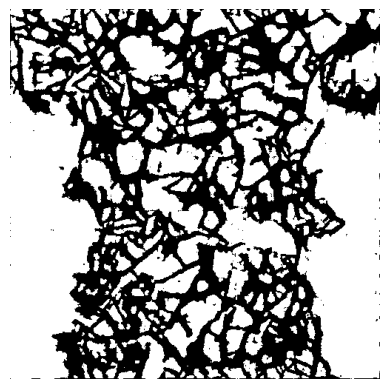

In [ ]:
## STEP 3: Load image and perform segmentation
if image_type == "afm":
    print("Processing AFM image...")
    import silkfn.segment as segment
    ### Load image; note that cv2.imread() returns images in BGR format
    image_feedIn = cv2.imread(image_path)
    ### Load the segmentation model
    segment_model = segment.afm_segment(model_name="silkfn/segment_model/ConvNN_l2.h5")
    ### Set segmentation scales: adjust the numbers in num_list (default: (5,7,11,13)).
    ### These four values mean four different scales will be used; larger values yield finer segmentation.
    split_list = segment_model.split_segment(image_feedIn, num_list=(5, 7, 11, 13))
    ### Set filtering threshold: an empirical value between 0.03 and 0.2.
    ### Larger values discard more segments. 0.1 is recommended for initial testing.
    image_feedIn = segment_model.posterior_check(threshold=0.03, split_list=split_list)
    image_feedIn = cv2.resize(image_feedIn, (target_size, target_size))
    ### Convert the segmentation result to a binary image
    image_feedIn = np.sign(image_feedIn).astype(np.uint8)
    plt.imshow(image_feedIn, cmap="binary")
    plt.axis('off')
    ### Save the segmentation result (image_feedIn) into the image_path directory as "mask.npy"
    np.save(os.path.join('data', image_name, 'mask.npy'), image_feedIn)
    ### Print the save location of the mask
    print(f"Mask saved at: {os.path.join('data', image_name, 'mask.npy')}")

elif image_type == "mask":
    print("Processing mask image...")
    image_feedIn = cv2.imread(image_path)[:, :, 0]
    image_feedIn = 255 - cv2.resize(image_feedIn, (target_size, target_size))
    image_feedIn = np.sign(image_feedIn)
    image_feedIn = ndimage.distance_transform_edt(image_feedIn) > 0
    plt.imshow(image_feedIn, cmap="binary")
    plt.axis('off')
    plt.colorbar()
    ### Save the segmentation result (image_feedIn) into the image_path directory as "mask.npy"
    np.save(os.path.join('data', image_name, 'mask.npy'), image_feedIn)
    ### Print the save location of the mask
    print(f"Mask saved at: {os.path.join('data', image_name, 'mask.npy')}")

Skeleton saved at: data\8.jpg\skeleton.npy
Structure saved at: data\8.jpg\structure.npy
Node list saved at: data\8.jpg\node_list.npy
Connection list saved at: data\8.jpg\connection_list.npy


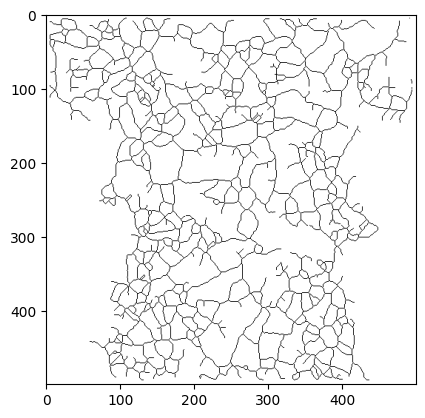

In [ ]:
## STEP 4: Reconstruction and calculation
import silkfn.network_builder as build
import silkfn.node_collect as node_collect

### Detect the skeleton
check = build.segment_thin.get_largest_connect(image_feedIn)
mask = check.copy()
skeleton = build.segment_thin.give_skeleton(check)
skeleton = skeleton / 255  # np.sign(skeleton)
plt.imshow(skeleton, cmap="binary")

structure = node_collect.get_structure(skeleton)

### Save skeleton and structure into the image_path directory as "skeleton.npy" and "structure.npy"
np.save(os.path.join('data', image_name, 'skeleton.npy'), skeleton)
np.save(os.path.join('data', image_name, 'structure.npy'), structure)

### Print save locations for skeleton and structure
print(f"Skeleton saved at: {os.path.join('data', image_name, 'skeleton.npy')}")
print(f"Structure saved at: {os.path.join('data', image_name, 'structure.npy')}")

### Node classification and identification
node_find_process = node_collect.network_node_refine(
    structure=os.path.join('data', image_name, 'structure.npy'),
    skeleton=os.path.join('data', image_name, 'skeleton.npy'),
    shape=(target_size, target_size)
)
find_node = node_find_process.find_node()
node_list = node_find_process.node_list_refine()
connection_list, connection_update = node_find_process.connection_refine(node_list, return_dict=True)

### Save node information into the image_path directory as "node_list.npy" and "connection_list.npy"
np.save(os.path.join('data', image_name, 'node_list.npy'), node_list)
np.save(os.path.join('data', image_name, 'connection_list.npy'), connection_list)

### Print save locations for node_list and connection_list
print(f"Node list saved at: {os.path.join('data', image_name, 'node_list.npy')}")
print(f"Connection list saved at: {os.path.join('data', image_name, 'connection_list.npy')}")

In [ ]:
## STEP 5: Path identification (time-consuming)
import silkfn.edge_collect as edge_collect
import networkx as nx

### A tqdm progress bar will show the remaining time.
edge_find_process = edge_collect.network_edge_refine(
    node_list=node_list,
    connection=connection_list)

### Load previously saved initial paths if they exist
if os.path.exists(os.path.join('data', image_name, 'init_paths.npy')):
    edge_find_process.initPaths = np.load(os.path.join('data', image_name, 'init_paths.npy'))
    print("Loaded existing init paths from file.")
else:
    edge_find_process.find_initPaths()

print(edge_find_process.initPaths.shape[0])

### Save the path-identification result into the image_path directory as "init_paths.npy"
init_paths = edge_find_process.initPaths
np.save(os.path.join('data', image_name, 'init_paths.npy'), init_paths)

### Print the save location of init_paths
print(f"Initial paths saved at: {os.path.join('data', image_name, 'init_paths.npy')}")

### Path-optimization algorithm
edge_find_simple = edge_collect.edge_opt(
    node_list=node_list,
    path_list=edge_find_process.initPaths)

edge_find_simple.opt_redundantNode()

fullGraph = edge_find_process.fullPathGraph
simpleGraph = edge_find_simple.Graph

branch_nodes = edge_collect.edge_merge.degree_check(
    full_graph=fullGraph,
    simple_graph=simpleGraph,
    bunch=edge_find_simple.true_node_index)

removed_edges = edge_collect.edge_merge.branch_opt(
    branch_nodes=edge_find_simple.true_node_index,
    full_graph=fullGraph,
    simple_graph=simpleGraph)

edge_find_simple.remove_edges(remove=removed_edges)

  0%|          | 0/379756 [00:00<?, ?it/s]

Total nodes: 872
1496
Initial paths saved at: data\8.jpg\init_paths.npy
51 / 872 nodes were removed during opt_redundantNode
80 / 1496 edges were removed during opt_redundantNode
352 / 1416 branch edges removed


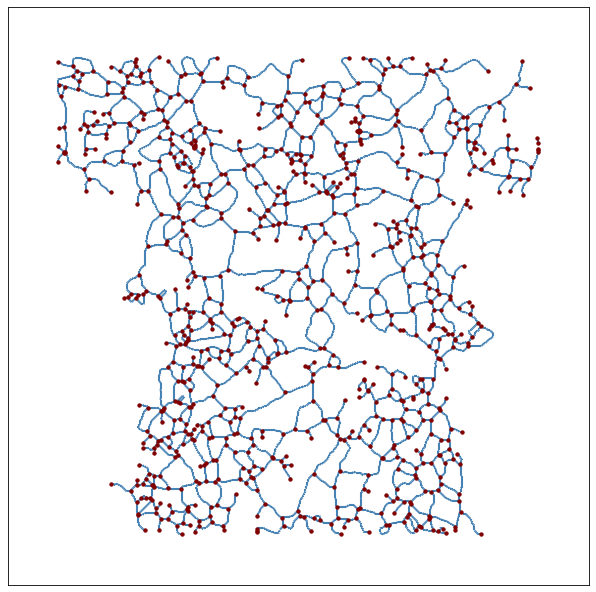

In [ ]:
## STEP 6: Visualization
fullGraph = edge_find_process.load_fullPathGraph()
full_node  = fullGraph.nodes()
full_edge  = fullGraph.edges()

simpleGraph = edge_find_simple.load_Graph()
simple_node = simpleGraph.nodes()
simple_edge = simpleGraph.edges()

plt.figure(figsize=(10, 10), dpi=75)
nx.draw_networkx_nodes(
    fullGraph,
    edge_find_process.npos,
    nodelist=edge_find_process.true_node_index,
    node_size=10,
    node_color="maroon"
)
nx.draw_networkx_edges(
    fullGraph,
    edge_find_process.npos,
    edgelist=full_edge,
    edge_color='steelblue',
    width=2
)
plt.gca().invert_yaxis()

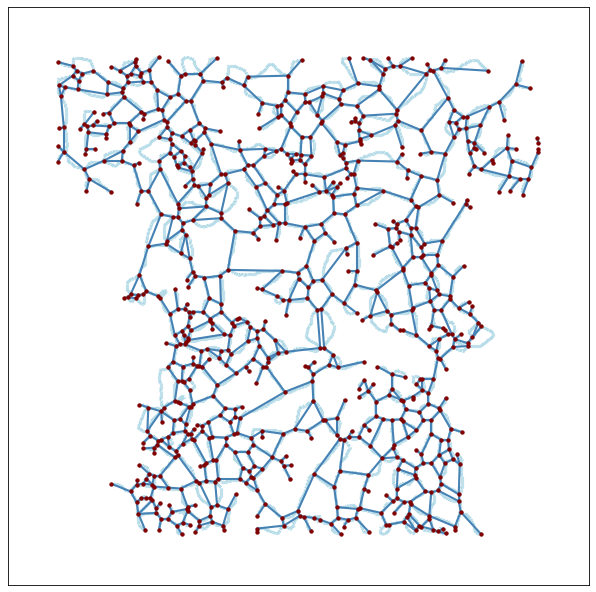

In [ ]:
plt.figure(figsize=(10,10),dpi=75)
nx.draw_networkx_nodes(fullGraph, 
                       edge_find_process.npos, 
                       nodelist=edge_find_simple.true_node_index, 
                       node_size=10, node_color="maroon")  
nx.draw_networkx_edges(fullGraph, 
                       edge_find_process.npos, 
                       edgelist=full_edge,
                       edge_color='lightblue',width=3) 
nx.draw_networkx_edges(simpleGraph, 
                       edge_find_process.npos, 
                       edgelist=simple_edge,
                       edge_color='steelblue',width=2) 
plt.gca().invert_yaxis()

In [ ]:
## STEP 7: Second round of optimization—remove spurious branches
edge_dual_opt = edge_collect.dual_opt(simpleGraph, fullGraph, node_list[:, 1:3])
edge_dual_opt.build_dual_graph()
dualGraph = edge_dual_opt.dual_graph

edge_dual_opt.cluster2fiber()

opt_graph = nx.Graph()
opt_graph.add_nodes_from(node_list[:, 0])
opt_graph.add_edges_from(edge_dual_opt.opt_edges)

SBR_opt = edge_collect.small_branch_remove(
    opt_graph=opt_graph,
    npos=edge_find_process.npos)

# Identify small branches for removal (branch length threshold = 10)
SBR_delete_nodes, SBR_delete_edges = SBR_opt.find_redundantNodes(branchThresh=10)

# Apply removal and return the optimized graph
SBR_opt.return_opt_graph(SBR_delete_edges)

d:\LabResearch\fn_v3.29\silkfn\edge_collect.py:566: RuntimeWarning: invalid value encountered in arccos
  cluster_res.append([cluster[0],cluster[1], np.around(np.rad2deg(np.arccos(cost)),0)])


Small branches removed: 73


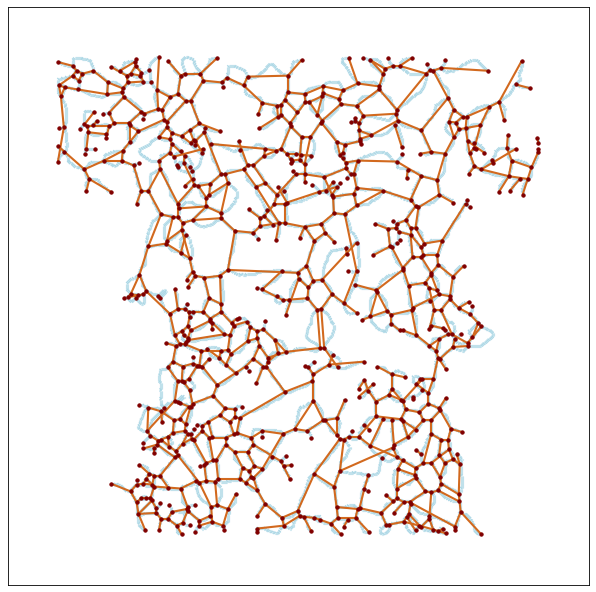

In [10]:
plt.figure(figsize=(10,10),dpi=75)
nx.draw_networkx_nodes(fullGraph, 
                       edge_find_process.npos, 
                       nodelist=edge_find_simple.true_node_index, 
                       node_size=10, node_color="maroon")  # 绘制节点
nx.draw_networkx_edges(fullGraph, 
                       edge_find_process.npos, 
                       edgelist=full_edge,
                       edge_color='lightblue',width=3)  # 绘制边
nx.draw_networkx_edges(SBR_opt.new_opt_graph, 
                       edge_find_process.npos, 
                       edgelist=SBR_opt.new_opt_graph.edges,
                       edge_color='chocolate',width=2)  # 绘制边
plt.gca().invert_yaxis()

In [ ]:
## STEP 8: Compute path-level statistics (note: unit conversion already applied—1 pix = 2 nm)
from silkfn.utils import (
    calculate_path_length,
    calculate_curvature_radius,
    calculate_endpoint_distance,
    calculate_continuous_length
)

edge_statistic = []
for edge in list(SBR_opt.new_opt_graph.edges):
    node_1, node_2 = edge[0], edge[1]
    path = nx.shortest_path(fullGraph, node_1, node_2)
    coord = [edge_find_process.npos[x] for x in path]
    if len(path) > 3:
        edge_statistic.append([
            calculate_path_length(coord),
            calculate_curvature_radius(coord),
            calculate_endpoint_distance(coord),
            calculate_continuous_length(coord)
        ])

edge_statistic = np.array(edge_statistic) * 2  # Convert pixels to nanometers

### Save the results to the image_path directory as "edge_statistic.txt"
np.savetxt(
    os.path.join('data', image_name, "edge_statistic.txt"),
    edge_statistic,
    fmt="%.3f",
    delimiter=" "
)

In [ ]:
# STEP 9: Write LAMMPS (lmp) file
from silkfn.lmp_write_in import lmp_write, multi_strand_discover
msd_main = multi_strand_discover(fullGraph = fullGraph,
                                 simpleGraph = SBR_opt.new_opt_graph,
                                 npos = edge_find_process.npos,
                                 mask = mask,
                                 mode = "only",
                                 max_display = 3)
msd_bunch = multi_strand_discover(fullGraph = fullGraph,
                                  simpleGraph = SBR_opt.new_opt_graph,
                                  npos = edge_find_process.npos,
                                  mask = mask,
                                  mode = bunch_mode,
                                  max_display = 3)
lmp_wp = lmp_write(msd_main = msd_main,
                   msd_bunch = msd_bunch,
                   bunch = if_bunch)

856 bunch pair found based on bunchTresh=0


  0%|          | 0/856 [00:00<?, ?it/s]

856 generated


In [13]:
lmp_wp.collect_atom_bond_information()
lmp_wp.write_lmp_datafile(path = os.path.join('data', image_name, "data.data"),
                          box_range = [-5, target_size+5, -5, target_size+5, -5, 5])